In [5]:
# Importando todas as bibliotecas necessárias
import torch
import matplotlib.pyplot as plt
import networkx as nx

# Imports do PyTorch Geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
# IMPORTAÇÃO CORRIGIDA E ADICIONAL:
from torch_geometric.explain import Explainer, GNNExplainer

# IMPORTANTE: Importando NOSSAS classes dos arquivos .py
import sys
sys.path.append('..')
from src.models import GCN

In [6]:
# --- PASSO 1: CARREGAR DADOS E MODELO TREINADO ---

# Carregar o dataset Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Instanciar a arquitetura do nosso modelo
model = GCN(num_features=dataset.num_features, 
            hidden_channels=16, 
            num_classes=dataset.num_classes)

# Carregar os pesos do modelo
model.load_state_dict(torch.load('../gcn_cora.pth'))
model.eval()
print("Modelo e dados carregados com sucesso!")

Modelo e dados carregados com sucesso!


In [56]:
# --- PASSO 2: CONFIGURAR E EXECUTAR O EXPLICADOR (NOVA API) ---

# 1. Crie o objeto 'Explainer' principal
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    # ADICIONE ESTAS DUAS LINHAS:
    node_mask_type='object', # Para gerar uma máscara de importância para os nós
    edge_mask_type='object', # Para gerar uma máscara de importância para as arestas
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# Escolher um nó para explicar
# Nós do conjunto de teste começam a partir do índice 1708 até 2707
node_idx = 1709

print(f"\nGerando explicação para o nó {node_idx}...")
# Chame o 'Explainer' para gerar a explicação para o nó específico
explanation = explainer(data.x, data.edge_index, index=node_idx)

# As máscaras agora estão dentro do objeto 'explanation'
edge_mask = explanation.edge_mask
print("Explicação gerada com sucesso!")


Gerando explicação para o nó 1709...
Explicação gerada com sucesso!


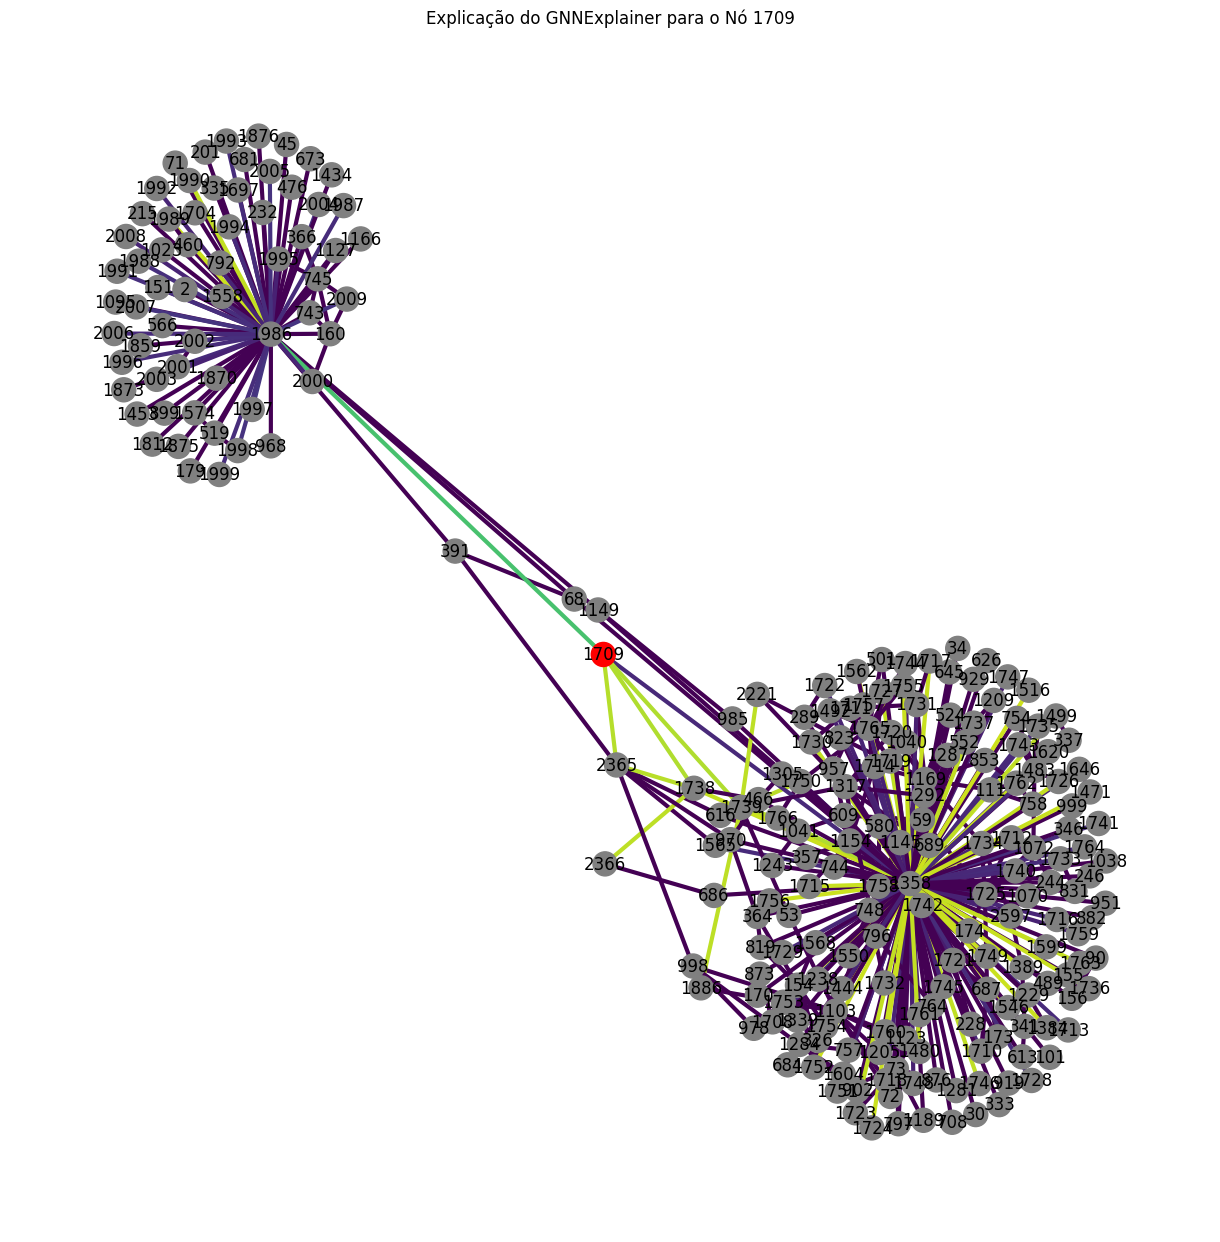

In [57]:
# --- PASSO 3: VISUALIZAR A EXPLICAÇÃO (com a correção) ---

# Converter o grafo do PyG para um formato que o NetworkX entende
G = to_networkx(data, to_undirected=True)
# Extrair o subgrafo da vizinhança
subgraph_nodes = list(nx.ego_graph(G, n=node_idx, radius=2).nodes())
subgraph = G.subgraph(subgraph_nodes)
# Preparar as cores dos nós
node_colors = ['red' if node == node_idx else 'gray' for node in subgraph.nodes()]

# Associar a máscara de arestas às arestas do subgrafo
subgraph_edge_weights = []
for u, v in subgraph.edges():
    # Encontrar a aresta (u,v) ou (v,u) na lista original de arestas
    mask_val_tensor = edge_mask[
        ((data.edge_index[0] == u) & (data.edge_index[1] == v)) |
        ((data.edge_index[0] == v) & (data.edge_index[1] == u))
    ]
    # Pegamos o primeiro item do tensor antes de convertê-lo
    mask_val = mask_val_tensor[0].item()
    subgraph_edge_weights.append(mask_val)

# Desenhar o grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors,
        width=3,
        edge_color=subgraph_edge_weights,
        edge_cmap=plt.cm.viridis, # Amarelo=importante, Roxo=não importante
        edge_vmin=0, edge_vmax=1)

plt.title(f"Explicação do GNNExplainer para o Nó {node_idx}")
plt.show()

In [58]:
# --- PASSO 4: AVALIAR A EXPLICAÇÃO COM MÉTRICAS ---

# CORREÇÃO: Adicione estas duas linhas para que o notebook encontre a pasta 'src'
import sys
sys.path.append('..')

# Importar nossas novas funções de métricas
from src.metrics import calculate_fidelity, calculate_sparsity

# Calcular as métricas usando as variáveis que já temos (model, data, edge_mask, etc.)
fid_plus = calculate_fidelity(model, node_idx, data, edge_mask, fidelity_type='+')
fid_minus = calculate_fidelity(model, node_idx, data, edge_mask, fidelity_type='-')
sparsity = calculate_sparsity(edge_mask)

# Imprimir os resultados de forma organizada
print("\n--- Métricas de Avaliação da Explicação ---")
print(f"Fidelidade+ (Suficiência): {fid_plus:.4f}")
print(f"  -> (Quanto menor, melhor. Indica que as arestas importantes são suficientes)")
print(f"\nFidelidade- (Necessidade): {fid_minus:.4f}")
print(f"  -> (Quanto maior, melhor. Indica que as arestas importantes são necessárias)")
print(f"\nConcisão (Sparsity): {sparsity:.4f}")
print(f"  -> (Quanto maior, melhor. Indica uma explicação mais focada)")


--- Métricas de Avaliação da Explicação ---
Fidelidade+ (Suficiência): -8.3560
  -> (Quanto menor, melhor. Indica que as arestas importantes são suficientes)

Fidelidade- (Necessidade): 9.5928
  -> (Quanto maior, melhor. Indica que as arestas importantes são necessárias)

Concisão (Sparsity): 0.9755
  -> (Quanto maior, melhor. Indica uma explicação mais focada)


In [59]:
# --- PASSO 5: VERIFICAR SE A CLASSIFICAÇÃO FOI CORRETA ---

# Obter todas as predições do modelo para o grafo
with torch.no_grad():
    all_predictions_logits = model(data.x, data.edge_index)

# Obter a classe que o modelo previu para o nosso nó específico
predicted_class = all_predictions_logits[node_idx].argmax().item()

# Obter a classe verdadeira do nosso nó (o "gabarito")
true_class = data.y[node_idx].item()

# CORREÇÃO: Definimos a lista de nomes de classes manualmente
class_names = [
    'Theory', 
    'Reinforcement_Learning', 
    'Genetic_Algorithms', 
    'Neural_Networks', 
    'Probabilistic_Methods', 
    'Case_Based', 
    'Rule_Learning'
]

print(f"\n--- Verificação da Classificação para o Nó {node_idx} ---")
print(f"Classe Predita pelo Modelo: {predicted_class} ({class_names[predicted_class]})")
print(f"Classe Verdadeira do Nó:   {true_class} ({class_names[true_class]})")

if predicted_class == true_class:
    print("\nResultado: CLASSIFICAÇÃO CORRETA! ✅")
else:
    print("\nResultado: CLASSIFICAÇÃO INCORRETA! ❌")


--- Verificação da Classificação para o Nó 1709 ---
Classe Predita pelo Modelo: 2 (Genetic_Algorithms)
Classe Verdadeira do Nó:   2 (Genetic_Algorithms)

Resultado: CLASSIFICAÇÃO CORRETA! ✅
